# Integration with adult Pan-immune data - Myeloid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import time

Global seed set to 0


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv

In [4]:
## import utils
cwd = '../utils/scArches_utils'
sys.path.append(cwd)

import map_query_utils

In [5]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_myeloid_v2/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


In [6]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [7]:
%load_ext rpy2.ipython


In [8]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [9]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

### Save MYELOID scVI model with EnsemblIDs

In [12]:
split = "MYELOID_V2"
timestamp="20210429"
scvi_outs_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'

## Read old varnames
model_dir='scvi_' + split + '_model/'
var_names_model = pd.read_csv(scvi_outs_dir + model_dir + "var_names.csv", header=None)[0].values

## Make new model folder for model with EnsemblIDs
new_model_dir = model_dir.strip("/") +"_ENSID/"
bash_call = 'cp -r {o} {n}'.format(o=scvi_outs_dir + model_dir, n=scvi_outs_dir+new_model_dir)
os.system(bash_call)

## Save var_names
adata_ref_var = pd.read_csv(scvi_outs_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)
adata_ref_var.iloc[var_names_model]['GeneID'].to_csv(scvi_outs_dir + new_model_dir + "var_names.csv", header=None, index=False)

### Train on scVI models

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [10]:
merged_adata_file = 'panimmune_full_MYELOID_query.mapped2MYELOID_V2.withReference.h5ad'
split = "MYELOID_V2"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
data_dir ="/nfs/team205/ed6/data/Fetal_immune/"

In [11]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [12]:
merged_adata

AnnData object with n_obs × n_vars = 272805 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'anno_lvl_2_final_clean', 'organ_code', 'donor', 'method', 'Category', 'dataset'
    uns: '_scvi', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [13]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [14]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values

merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [15]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
query_anno_obs = merged_adata[query_obs].obs.copy()
merged_adata.obs["annotation_query"] = np.nan
df = query_anno_obs.loc[query_obs][["Category"]].astype("str").replace("nan", np.nan)
merged_adata.obs.loc[query_obs, "annotation_query"] = df["Category"].loc[query_obs].values

# merged_adata.obs["organ_code"] = np.nan
# merged_adata.obs.loc[query_obs, "organ_code"] = query_anno_obs.loc[query_obs.str.strip("-query")]["organ code"].values

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_myeloid_v2/scvelo_dataset_q2r.png


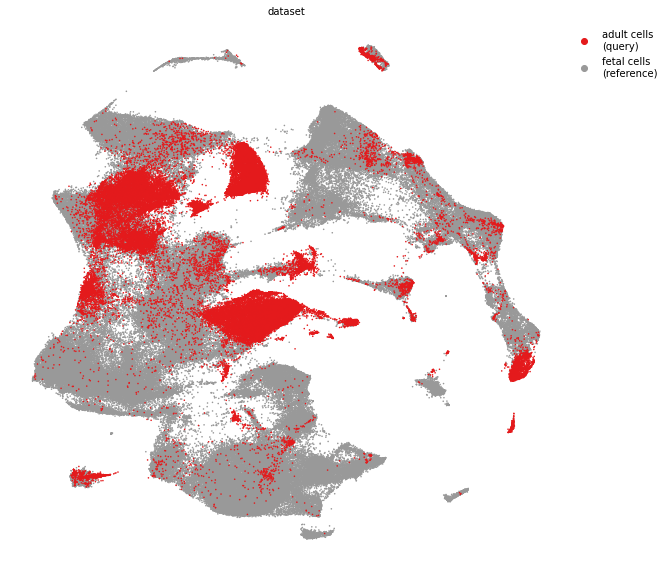

In [16]:
plt.rcParams["figure.figsize"] = [10,10]
merged_adata.obs['dataset_pl'] = ['fetal cells\n(reference)' if x=='reference' else 'adult cells\n(query)' for x in merged_adata.obs['dataset']]
scv.pl.umap(merged_adata, color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
            save="dataset_q2r.png"
           )

In [19]:
merged_adata.obs["dataset"].value_counts()

reference    218758
query         54047
Name: dataset, dtype: int64

### Plot query and reference annotations

In [22]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [20]:
anno_labels_pl = {
#     'Tnaive/CM_CD4_activated':'Tnaive/CM_CD4',
#     'Tem/emra_CD8':'Trm/em_CD8',
#     'Trm_gut_CD8':'Trm/em_CD8',
#     'Tgd_CRTAM+':'Tgd',
#     'Trm_Tgd':'Tgd',
    'GC_B (I)':'GC B',
    'GC_B (II)':'GC B'
}

plt.rcParams['figure.figsize'] = [12,12]
merged_adata.obs["annotation_query_pl"] = [anno_labels_pl[x] if x in anno_labels_pl.keys() else x for x in merged_adata.obs["annotation_query"]]
label_counts = merged_adata.obs["annotation_query_pl"].value_counts()
anno_labels = label_counts.index[label_counts > 10]

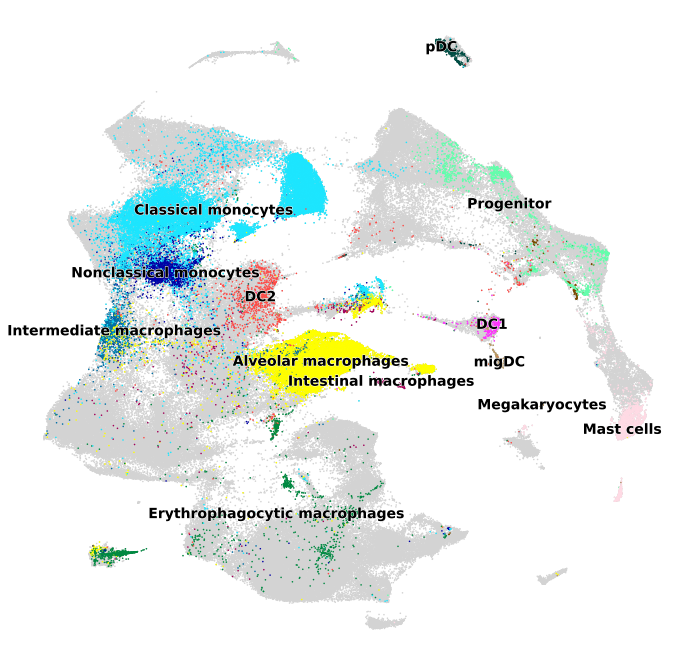

In [23]:
scv.pl.umap(merged_adata, color=["annotation_query_pl"], 
            size=10, 
            palette=sc.pl.palettes.godsnot_102,
            legend_loc="on data", groups=anno_labels, title="", 
            legend_fontsize=14, 
#             save="anno_query.png"
           )

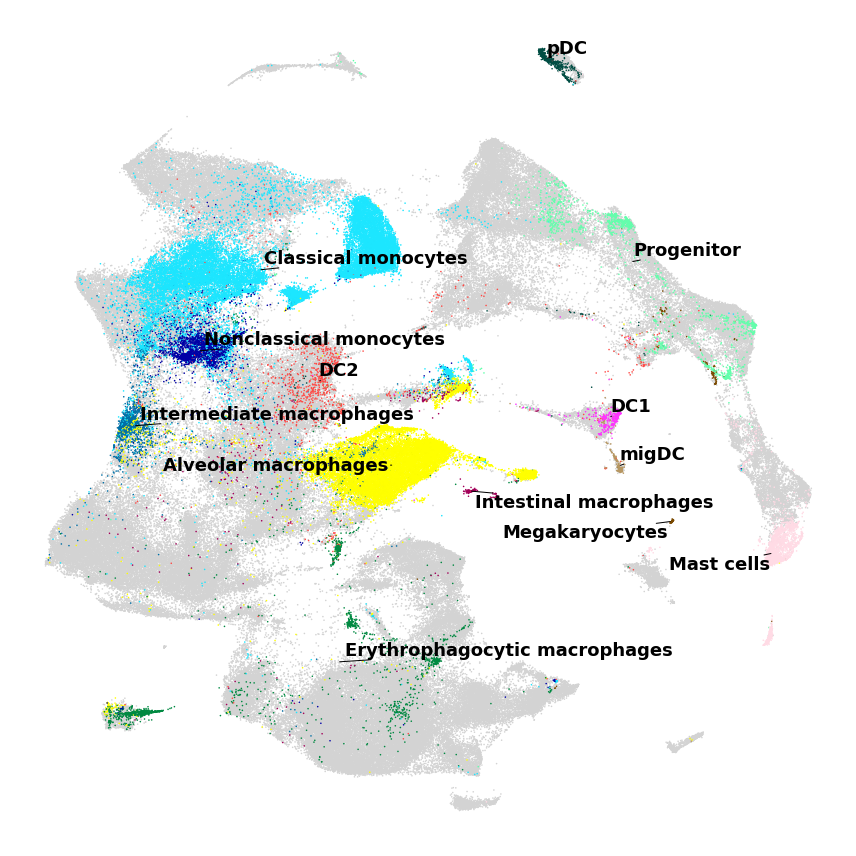

In [24]:
ax = sc.pl.umap(merged_adata, color=["annotation_query_pl"], 
            size=10, 
            palette=sc.pl.palettes.godsnot_102,
            legend_fontsize=14, frameon=False,
            title="", show=False, legend_loc=None)
gen_mpl_labels(
    merged_adata,
    "annotation_query_pl",
    exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=18, fontweight='bold'),
)
fig = ax.get_figure()
fig.tight_layout()
plt.savefig(figdir+"anno_query_fixedlabels.png")

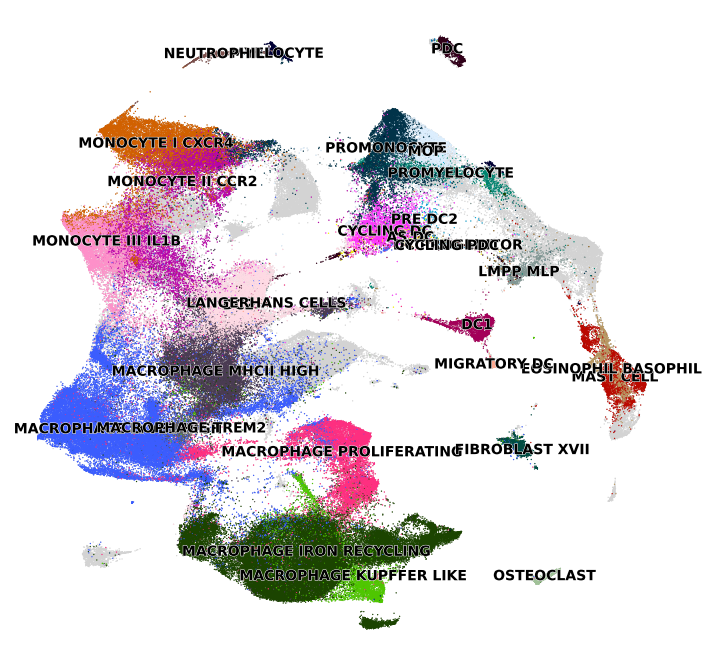

In [25]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["PROGENITORS"]]
anno_labels = [x for x in anno_labels if sum(merged_adata.obs['annotation_reference'] == x) > 30]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=14,
            title="",
#            save="anno_reference.png"
           )

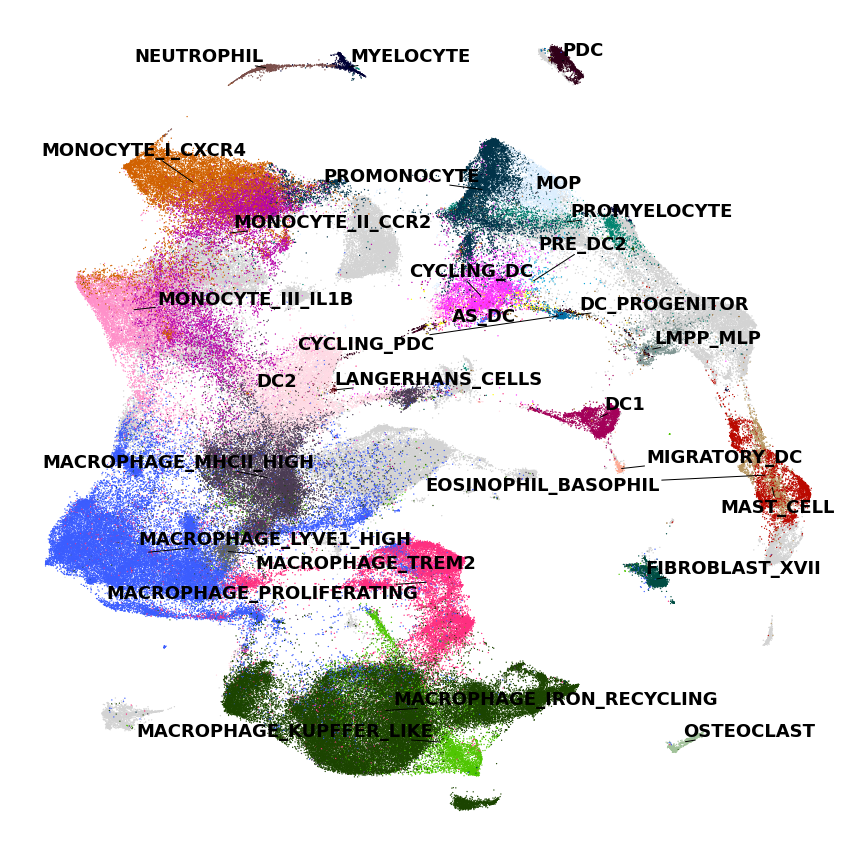

In [26]:
ax = sc.pl.umap(merged_adata, color=["annotation_reference"], size=7, groups=anno_labels, frameon=False,
            legend_fontsize=14,
            title="", show=False, legend_loc=None)
gen_mpl_labels(
    merged_adata,
    "annotation_reference",
    exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=18, fontweight='bold'),
)
fig = ax.get_figure()
fig.tight_layout()
plt.savefig(figdir+"anno_reference_fixedlabels.png")

In [31]:
sc.pp.normalize_total(merged_adata, target_sum=10e4)
sc.pp.log1p(merged_adata)

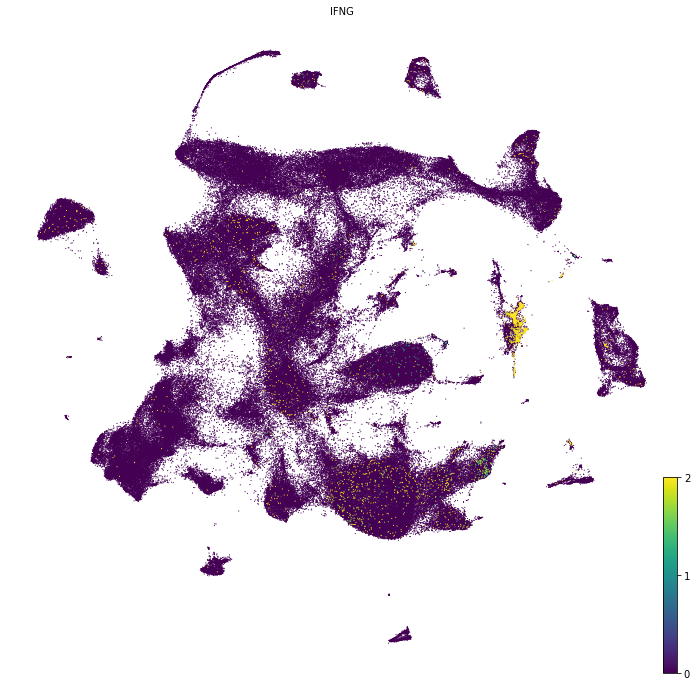

In [40]:
scv.pl.umap(merged_adata, color=['ENSG00000111537'], size=5, 
            legend_loc="on data",title=["IFNG"], ncols=2, vmax=2
           )

### Transfer labels

In [27]:
def predict_label2(merged_adata, anno_col = 'annotation_reference', k=50, min_score = 0.5):
    '''
    Predict annotation labels for query cells based on k-NNs in the reference data
    '''
    import time
    from scipy.spatial import cKDTree

    ## Extract embedding
    X_emb = merged_adata.obsm["X_scvi"].copy()

    is_query = merged_adata.obs["dataset"] == "query"
    is_reference = merged_adata.obs["dataset"] == "reference"

    X_emb_ref = X_emb[is_reference,:]
    X_emb_que = X_emb[is_query,:]

    ## Find nearest neighbors in reference
    k1=k2=k
    data_query = X_emb_que
    data_ref = X_emb_ref
    start = time.time()
    k_index_ref = cKDTree(data_ref).query(x=data_query, k=k1, n_jobs=5)[1]
    end = time.time()
    print(end - start)

    knn_mat = np.zeros(shape=[sum(is_query),sum(is_reference)])
    for i in range(k_index_ref.shape[0]):
        knn_mat[i, k_index_ref[i]] = 1

    ## Subset to reference cells that have are NN to at least one query cell
    keep_ref_ixs = np.unique(k_index_ref.ravel())
    keep_ref_ixs.sort()
    small_knn_mat = knn_mat[:,keep_ref_ixs]

    ## Make dummy matrix of annotations
    annos = merged_adata[is_reference].obs[anno_col][keep_ref_ixs].copy()
    dummy_df = pd.get_dummies(annos)
    dummy_mat = dummy_df.values

    ## Sum number of neighbors with each annotation
    new_anno = small_knn_mat.dot(dummy_mat)

    ## Find top scorers
    n_neighbors = np.array(small_knn_mat.sum(1)).flatten()
    n_neighbors_ref = new_anno.sum(axis=1)
    new_anno_prob = new_anno.T/n_neighbors_ref
    new_anno_prob[np.isnan(new_anno_prob)] = 0
    best_label = dummy_df.columns[new_anno_prob.argmax(0)].values
    best_label_score = new_anno_prob.max(0)
    best_label = best_label.astype('str')

    ## Call low confidence if probability is < min_score
    best_label_all = best_label.copy()
    best_label[best_label_score <= min_score] = "low_confidence"

    ## Save output in place
    del merged_adata.obs['predicted_anno'] 
    merged_adata.obs['predicted_anno'] = np.nan
    merged_adata.obs['predicted_anno_unfiltered'] = np.nan
    merged_adata.obs['predicted_anno_prob'] = np.nan
    merged_adata.obs.loc[is_query,'predicted_anno'] = best_label
    merged_adata.obs.loc[is_query,'predicted_anno_unfiltered'] = best_label_all
    merged_adata.obs.loc[is_query,'predicted_anno_prob'] = best_label_score

In [28]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
if 'predicted_anno' in merged_adata.obs.columns:
    merged_adata.obs.drop('predicted_anno', 1, inplace=True)

## Split query cells in batches (avoid eating all the RAM)
n_batches = 10
q_obs = merged_adata.obs_names[merged_adata.obs['dataset'] == 'query']
r_obs = merged_adata.obs_names[merged_adata.obs['dataset'] == 'reference']
b_size = q_obs.shape[0]//10

for c in ['predicted_anno', 'predicted_anno_unfiltered', 'predicted_anno_prob']:
    merged_adata.obs[c] = np.nan

i = 0
while i < q_obs.shape[0]:
    b_obs = q_obs[i:(i+b_size)]
    i += b_size
    
    ## Split query cells in batches (avoid eating all the RAM)
    b_merged_adata = merged_adata[r_obs.tolist() + b_obs.tolist()].copy()
    map_query_utils.predict_label2(b_merged_adata, anno_col="annotation_reference", k=100)

    for c in ['predicted_anno', 'predicted_anno_unfiltered', 'predicted_anno_prob']:
        merged_adata.obs.loc[b_obs,c] = b_merged_adata.obs.loc[b_obs,c]

5.061333894729614
8.395876407623291
4.985530376434326
6.758623361587524
7.402353525161743
6.590266942977905
7.619322061538696
5.965806245803833
5.967931747436523
5.2531962394714355
0.17307424545288086


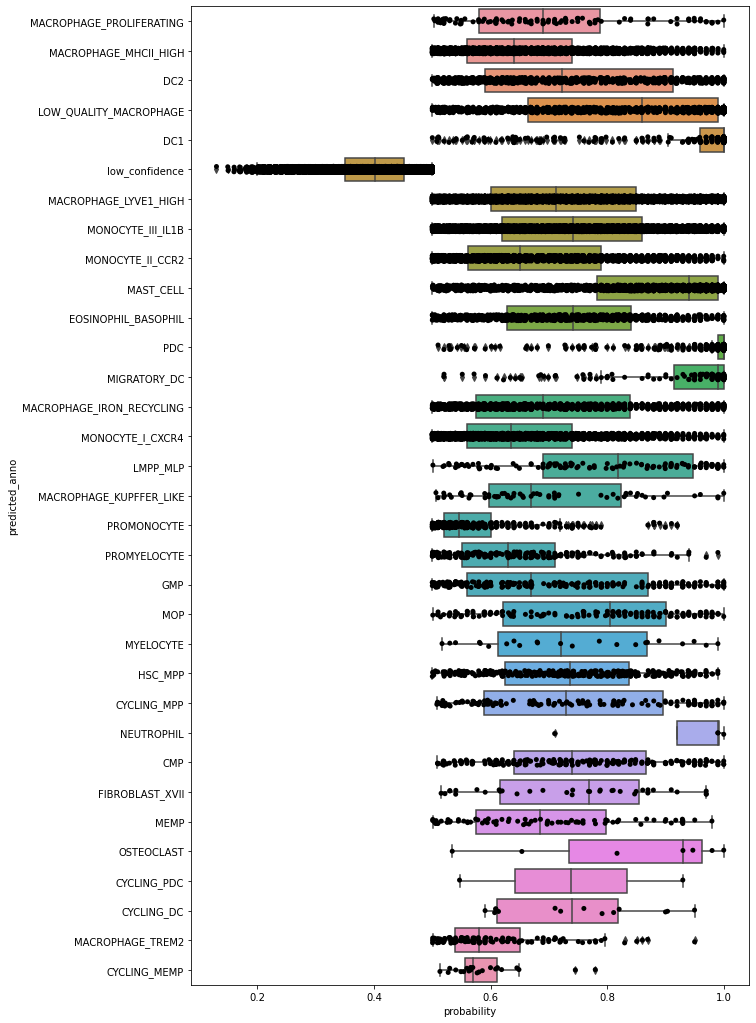

In [29]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

In [30]:
merged_adata.obs.loc[merged_adata.obs['predicted_anno_prob'] < 0.8, 'predicted_anno'] = 'low_confidence'

In [31]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)].copy()
merged_adata_clean.obs[query_anno_col] = merged_adata_clean.obs[query_anno_col].astype("str")

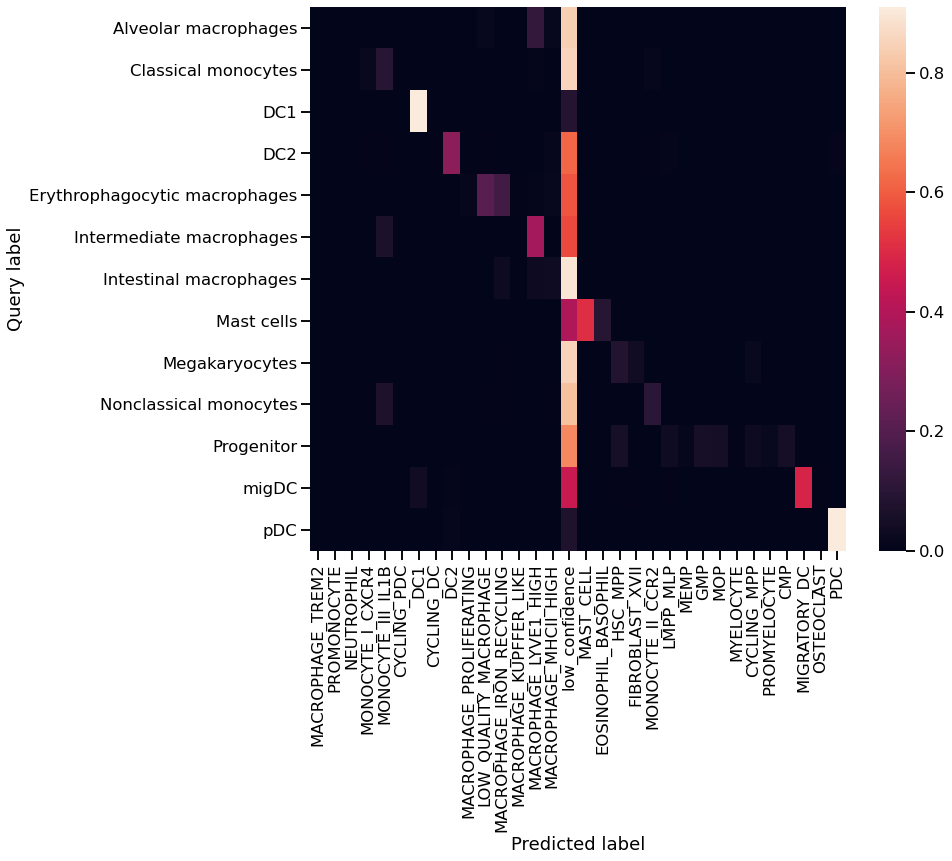

In [32]:
plt.rcParams["figure.figsize"] = [12,10]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

### Quantify matching between datasets

In [34]:
## Calculate distance of a query cell to closest cell of 
# predicted annotation

def _compute_min_dist2predicted_anno(merged_adata, r_cl,
#                                      q_cell,
                                     r_obs = 'annotation_reference',
                                     pred_anno_obs = 'predicted_anno_unfiltered'
                                    ):
    from scipy.spatial import cKDTree
    # Pick reference cluster 
    keep_ref_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)
    keep_query_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[pred_anno_obs] == r_cl)

    ## Calculate distance of query cell to all reference
    # cells in cluster
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_ref_cells,:]
    X_dims_invitro = X_dims[keep_query_cells,:]
    k_ref = cKDTree(X_dims_invivo).query(x=X_dims_invitro, k=1, n_jobs=5)
    min_dists = k_ref[0]
    min_dists_df = pd.DataFrame(zip(merged_adata.obs_names[keep_query_cells],min_dists), columns=['query_cell', 'min_distance2pred'])
    return(min_dists_df)

start = time.time()
merged_adata.obs['min_distance2pred'] = np.nan
counter = 0
is_query = merged_adata.obs["dataset"] == "query"
is_reference = merged_adata.obs["dataset"] == "reference"
for r_cl in merged_adata.obs['predicted_anno_unfiltered'].unique():
    counter += 1
    min_dists_df = _compute_min_dist2predicted_anno(merged_adata, r_cl)
    merged_adata.obs.loc[min_dists_df.query_cell, 'min_distance2pred'] = min_dists_df.min_distance2pred.values
    print(counter)
## Normalize w gaussian kernel
merged_adata.obs.loc[is_query, 'min_distance2pred'] = map_query_utils._scArches_adjusted_dist(merged_adata.obs.loc[is_query, 'min_distance2pred'].astype('float').values)
end = time.time()
print(end-start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
4.38658332824707


### Combined similarity & confusion matrix

In [36]:
q_df = merged_adata[merged_adata.obs['dataset'] == 'query'].obs[["min_distance2pred", "predicted_anno", "annotation_query", 'organ_code']]
q_df = q_df[~q_df.annotation_query.isna()]
q_df.annotation_query = q_df.annotation_query.astype('str')
q_df.min_distance2pred = q_df.min_distance2pred.astype('float')

In [44]:
q_df.predicted_anno.unique() 

array(['low_confidence', 'MACROPHAGE_MHCII_HIGH',
       'LOW_QUALITY_MACROPHAGE', 'DC1', 'MACROPHAGE_LYVE1_HIGH',
       'MONOCYTE_III_IL1B', 'MAST_CELL', 'PDC', 'DC2', 'MIGRATORY_DC',
       'MONOCYTE_II_CCR2', 'MACROPHAGE_IRON_RECYCLING',
       'EOSINOPHIL_BASOPHIL', 'MONOCYTE_I_CXCR4', 'LMPP_MLP', 'MOP',
       'PROMYELOCYTE', 'HSC_MPP', 'CYCLING_MPP', 'GMP',
       'MACROPHAGE_KUPFFER_LIKE', 'MEMP', 'MYELOCYTE',
       'MACROPHAGE_PROLIFERATING', 'OSTEOCLAST', 'CYCLING_PDC',
       'CYCLING_DC', 'CMP', 'FIBROBLAST_XVII', 'NEUTROPHIL',
       'PROMONOCYTE', 'MACROPHAGE_TREM2'], dtype=object)

In [45]:
query_anno_group_myeloid = {
    'Eo/baso/mast':['Progenitor','Mast cells'],
    "MACs":[x for x in q_df.annotation_query.unique() if "acrophage" in x] + ["Kupffer cells"],
    'DCs':[x for x in q_df.annotation_query.unique() if "DC" in x],
    "Mono":[x for x in q_df.annotation_query.unique() if "mono" in x],
    }

query_anno_group_myeloid['other'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_myeloid.values(),[])]
query_anno_group_myeloid_rev = {x:g for g,a in query_anno_group_myeloid.items() for x in a}

ref_anno_group_myeloid = {
    'Eo/baso/mast':['CMP','LMPP_MLP', 'MOP','EOSINOPHIL_BASOPHIL','MAST_CELL'],
    "MACs":[x for x in q_df.predicted_anno.unique() if "ACROPHAGE" in x],
    'DCs':[x for x in q_df.predicted_anno.unique() if "DC" in x],
    "Mono":[x for x in q_df.predicted_anno.unique() if "MONO" in x],
    'low_confidence':['low_confidence']
    }

ref_anno_group_myeloid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_myeloid.values(),[])]
ref_anno_group_myeloid_rev = {x:g for g,a in ref_anno_group_myeloid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_myeloid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_myeloid_rev[x] for x in q_df['predicted_anno']]

In [46]:
%%R -i q_df
head(q_df)

                                    min_distance2pred        predicted_anno
Pan_T7935490_AACCATGTCTCGTTTA-query         0.6734872        low_confidence
Pan_T7935490_CACACCTGTCGACTAT-query         0.5961646        low_confidence
Pan_T7935490_CGTAGGCCAATGGACG-query         0.6122920        low_confidence
Pan_T7935490_CGTCAGGCAGGGATTG-query         0.7403881 MACROPHAGE_MHCII_HIGH
Pan_T7935490_CTACACCAGCGCTCCA-query         0.6402326        low_confidence
Pan_T7935490_CTCGAAAAGCGATATA-query         0.6846537        low_confidence
                                                 annotation_query organ_code
Pan_T7935490_AACCATGTCTCGTTTA-query Erythrophagocytic macrophages        ILE
Pan_T7935490_CACACCTGTCGACTAT-query Erythrophagocytic macrophages        ILE
Pan_T7935490_CGTAGGCCAATGGACG-query Erythrophagocytic macrophages        ILE
Pan_T7935490_CGTCAGGCAGGGATTG-query Erythrophagocytic macrophages        ILE
Pan_T7935490_CTACACCAGCGCTCCA-query                           DC2        ILE
Pan_T7

In [50]:
%%R -i q_df -h 800 -w 1200 -i figdir 
pl_q_df <- q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(min_distance2pred)) %>%
    ungroup() %>%
    filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
    mutate(annotation_query_group=factor(annotation_query_group, levels=c('Eo/baso/mast','DCs','Mono', "MACs"))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
    mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('Eo/baso/mast','DCs','Mono', "MACs", ''))) 
#     mutate(predicted_anno=factor(predicted_anno, levels=order_ref_anno)) %>%
#     mutate(annotation_query=factor(annotation_query, levels=rev(order_que_anno)))

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


In [52]:
%%R -h 800 -w 1200 -i figdir
pl <- pl_q_df %>%
    distinct() %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="Spectral", direction=-1, name='Median\nsimilarity',
                        ) +
#     scale_fill_viridis_c(option='magma', name='Median\nsimilarity') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1),
          strip.text.y=element_text(angle=0), strip.text.x=element_text(angle=90)
         ) +

    ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=17, height=12) 

In [49]:
## Save for future plotting
q_df.to_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_MYELOID_query.mapped2MYELOID_V2.confusion_table.csv')

In [174]:
q_df = smp_merged_adata[smp_merged_adata.obs['dataset'] == 'query'].obs[["min_distance2pred", "predicted_anno_unfiltered", "annotation_query", 'organ_code', "predicted_anno_prob"]]
q_df = q_df[~q_df.annotation_query.isna()]
q_df.annotation_query = q_df.annotation_query.astype('str')
q_df.min_distance2pred = q_df.min_distance2pred.astype('float')

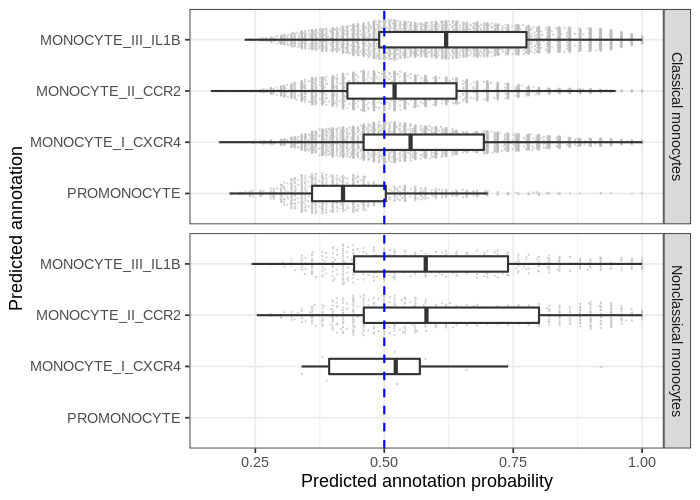

In [214]:
%%R -i q_df -h 500 -w 700
q_df %>%
    filter(str_detect(annotation_query, 'monocytes')) %>%
    filter(str_detect(predicted_anno_unfiltered, 'MONOCYTE')) %>%
    mutate(predicted_anno_unfiltered = factor(predicted_anno_unfiltered, c("PROMONOCYTE", "MONOCYTE_I_CXCR4", "MONOCYTE_II_CCR2", "MONOCYTE_III_IL1B"))) %>%
    ggplot(aes(predicted_anno_unfiltered, predicted_anno_prob)) +
#     geom_violin(scale='width') +
    ggbeeswarm::geom_quasirandom(size=0.5, alpha=0.5, color='grey') +
    geom_boxplot(width=0.3, outlier.alpha=0, size=1) +
    facet_grid(annotation_query~.) +
    coord_flip() +
    geom_hline(yintercept=0.5, linetype=2, color='blue', size=1) +
    theme_bw(base_size=18) +
    xlab("Predicted annotation") + ylab("Predicted annotation probability")

In [195]:
for monos in ['MONOCYTE_I_CXCR4', 'MONOCYTE_II_CCR2', 'MONOCYTE_III_IL1B']:
    q_df[q_df['predicted_anno'] == monos].value_counts("organ_code")

KeyError: 'predicted_anno'

In [56]:
q_df_monos = q_df[q_df['annotation_query'].isin(['MONOCYTE_I_CXCR4', 'MONOCYTE_II_CCR2', 'MONOCYTE_III_IL1B'])]
monos_organ = q_df_monos.groupby(['predicted_anno','organ_code'] ).size().reset_index()

In [194]:
monos_organ

,predicted_anno,organ_code,0


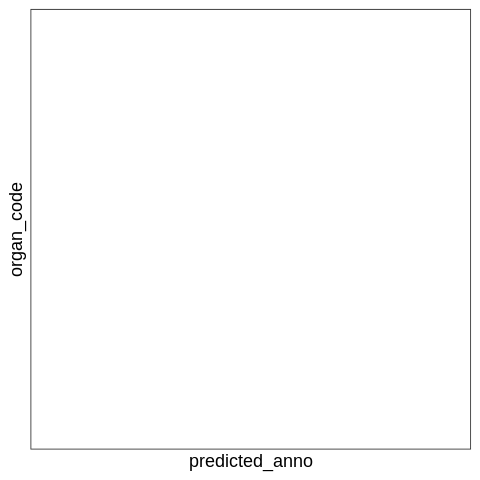

In [59]:
%%R -i monos_organ -i figdir
monos_organ %>%
    rename(n_cells=`0`) %>%
    ggplot(aes(predicted_anno,`organ_code`, fill= n_cells)) +
    geom_tile() +
    geom_text(aes(label=n_cells)) +
    scale_fill_distiller(palette="Reds", direction=1) +
    theme_bw(base_size=18) +
    theme(axis.text.x=element_text(angle=90)) +
    ggsave(paste0(figdir, 'predicted_monocytes_organ_distribution.pdf'), width=7, height=8)

In [148]:
smp_merged_adata.var_names = smp_merged_adata.var.GeneName.values.copy()

In [153]:
merged_adata.var_names = merged_adata.var_names.astype("str")

In [154]:
merged_adata.var_names_make_unique()

In [158]:
sc.pp.normalize_total(merged_adata, target_sum=10e4)
sc.pp.log1p(merged_adata)

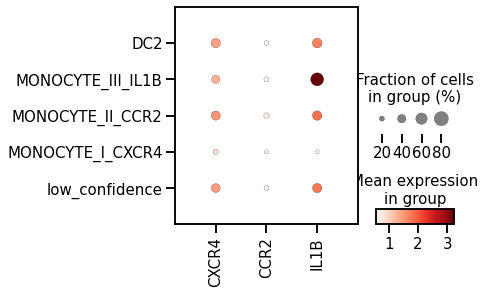

In [199]:

sc.pl.dotplot(merged_adata[q_df_monos.index],['CXCR4', "CCR2", "IL1B"] ,groupby='predicted_anno', 
                    figsize=[5, 4], save='mono_adult.pdf')
# fig.savefig(figdir+'dotplot_mono_adult.pdf',bbox='tight')

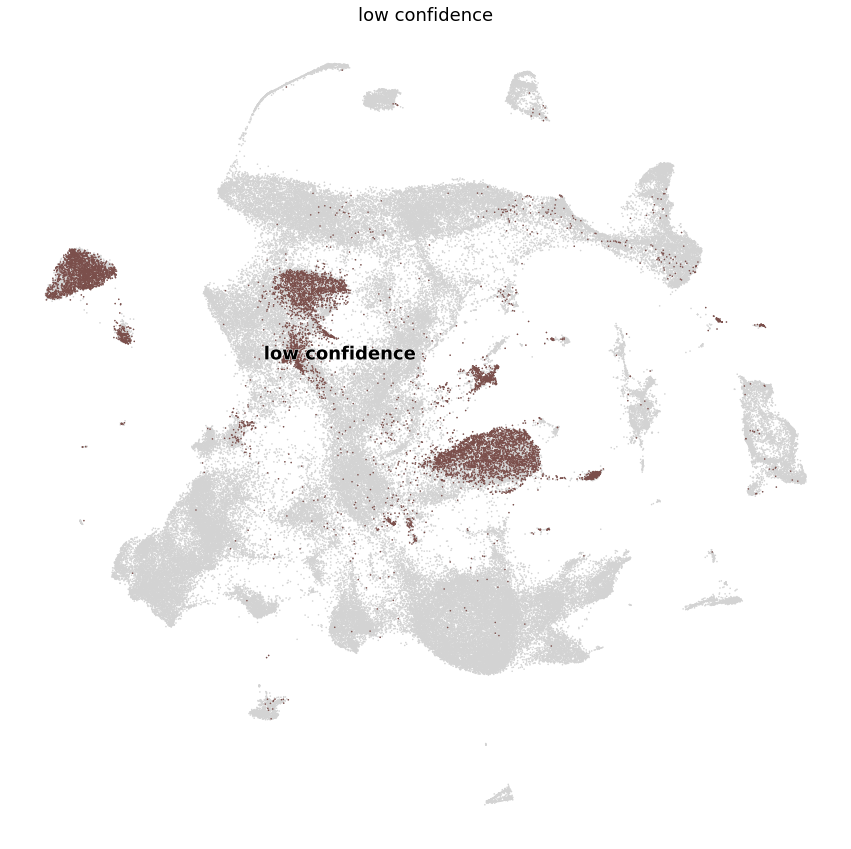

In [110]:
plt.rcParams['figure.figsize'] = [15,15]
scv.pl.umap(smp_merged_adata, color='predicted_anno', size=10, groups=['low_confidence'])

In [217]:
merged_adata.obs[merged_adata.obs['annotation_query'].isin(["Erythrophagocytic macrophages"])].value_counts('organ code')

organ code
SPL    705
LIV    389
MLN     86
TLN     58
DUO     37
BMA     27
LNG     17
ILE     17
OME     14
SKM      4
TCL      3
CAE      3
SCL      2
nan      0
THY      0
BLD      0
dtype: int64

### Save outputs

In [38]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

In [ ]:
merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

## Mapping validation metrics

In [17]:
query_mapped_adata = merged_adata[merged_adata.obs['dataset'] == 'query'].copy()

sc.pp.neighbors(query_mapped_adata, use_rep='X_scvi', n_neighbors=30)

In [29]:
sc.tl.leiden(query_mapped_adata, resolution=0.5)

In [30]:
query_mapped_adata.obs['leiden'] = query_mapped_adata.obs['leiden'].astype("str")
query_mapped_adata.obs['annotation_query'] = query_mapped_adata.obs['annotation_query'].astype("str")

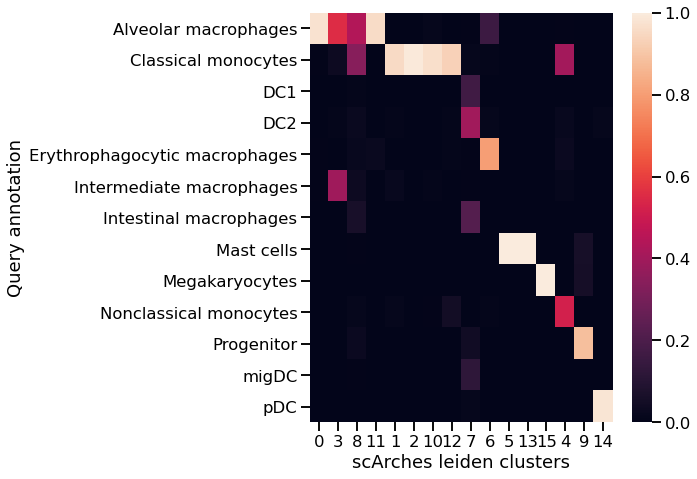

In [31]:
sns.set_context("talk")
keep_cts = query_mapped_adata.obs['annotation_query'].value_counts().index[query_mapped_adata.obs['annotation_query'].value_counts() > 10]
keep_cts = keep_cts[keep_cts!='nan']
conf_mat = sc.metrics.confusion_matrix('leiden','annotation_query', 
                                       query_mapped_adata.obs[query_mapped_adata.obs['annotation_query'].isin(keep_cts)]).T

col_order = conf_mat.idxmax(0).sort_values().index
conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal

plt.rcParams['figure.figsize'] = [10, 7]
sns.heatmap(conf_mat, xticklabels=True, yticklabels=True);
plt.xlabel("scArches leiden clusters");
plt.ylabel("Query annotation");
plt.tight_layout();
plt.savefig(figdir + 'validation_conf_mat.pdf')

In [25]:
pip_data = sc.read_h5ad('/nfs/team205/cx1/Celltypist/revision_science/data/PIP_global_object.h5ad', backed='r')

In [26]:
query_mapped_adata.obs['leiden_old'] = pip_data.obs.loc[query_mapped_adata.obs_names.str.strip("-query"), 'leiden'].values
query_mapped_adata.obs['batch'] = pip_data.obs.loc[query_mapped_adata.obs_names.str.strip("-query"), 'donor_id'].values

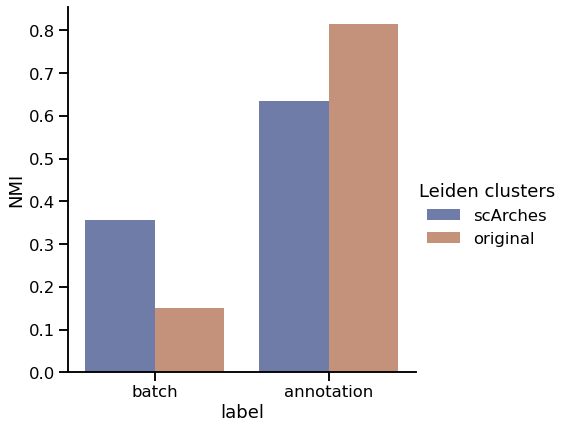

In [32]:
import sklearn
nmi_anno_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden_old"])
nmi_anno_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden"])
nmi_batch_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden_old"])
nmi_batch_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden"])

df = pd.DataFrame([nmi_batch_new, nmi_batch_old,nmi_anno_new, nmi_anno_old])
df.columns = ['NMI']
df['cat'] = ['batch_scArches', 'batch_original', 'annotation_scArches', "annotation_original"]
df['Leiden clusters'] = [x[1] for x in df['cat'].str.split("_")]
df['label'] = [x[0] for x in df['cat'].str.split("_")]

sns.catplot(
    data=df, kind="bar",
    x="label", y="NMI", hue='Leiden clusters',
    ci="sd", palette="dark", alpha=.6, height=6
)
plt.savefig(figdir + 'validation_barplot.pdf')